In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 580ms/step - loss: 0.0579
Average validation loss: 0.1318207085132599
4/4 [==============================] - 6s 594ms/step - loss: 0.0579 - val_loss: 0.1318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 581ms/step - loss: 0.0442 - val_loss: 0.1318
Average validation loss: 0.1296568065881729
4/4 [==============================] - 8s 596ms/step - loss: 0.0442 - val_loss: 0.1307
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 578ms/step - loss: 0.0339 - val_loss: 0.1307
Average validation loss: 0.1420171707868576
4/4 [==============================] - 10s 593ms/step - loss: 0.0339 - val_loss: 0.1345
Epoch 4/10
4/4 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 588ms/step - loss: 0.0018
Average validation loss: 0.38777226209640503
8/8 [==============================] - 5s 599ms/step - loss: 0.0018 - val_loss: 0.3878
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 10s 597ms/step - loss: 0.0016 - val_loss: 0.3878
Average validation loss: 0.11243245750665665
8/8 [==============================] - 10s 608ms/step - loss: 0.0016 - val_loss: 0.2501
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 14s 587ms/step - loss: 0.0015 - val_loss: 0.2501
Average validation loss: 0.13377992063760757
8/8 [==============================] - 15s 598ms/step - loss: 0.0015 - val_loss: 0.2113
Epoch 4/10
8/8 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 7s 593ms/step - loss: 0.0017
Average validation loss: 0.16602398455142975
12/12 [==============================] - 7s 603ms/step - loss: 0.0017 - val_loss: 0.1660
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 14s 592ms/step - loss: 0.0016 - val_loss: 0.1660
Average validation loss: 0.1794519970814387
12/12 [==============================] - 15s 602ms/step - loss: 0.0016 - val_loss: 0.1727
Epoch 3/10
12/12 [==============================] - 22s 592ms/step - loss: 0.0017 - val_loss: 0.1727
Average validation loss: 0.13723561664422354
12/12 [==============================] - 22s 602ms/step - loss: 0.0017 - val_loss: 0.1609
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_15.pth'.
Epoch 4/10
12/12 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 10s 594ms/step - loss: 0.0016
Average validation loss: 0.14897315204143524
16/16 [==============================] - 10s 605ms/step - loss: 0.0016 - val_loss: 0.1490
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 19s 597ms/step - loss: 0.0014 - val_loss: 0.1490
Average validation loss: 0.14675837382674217
16/16 [==============================] - 19s 606ms/step - loss: 0.0014 - val_loss: 0.1479
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 29s 596ms/step - loss: 0.0014 - val_loss: 0.1479
Average validation loss: 0.13536177575588226
16/16 [==============================] - 29s 606ms/step - loss: 0.0014 - val_loss: 0.1437
Saved model weights to 'c:\U

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 12s 598ms/step - loss: 9.5591e-04
Average validation loss: 0.17770155370235444
20/20 [==============================] - 12s 608ms/step - loss: 9.5591e-04 - val_loss: 0.1777
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 24s 598ms/step - loss: 8.8654e-04 - val_loss: 0.1777
Average validation loss: 0.16939696669578552
20/20 [==============================] - 24s 607ms/step - loss: 8.8654e-04 - val_loss: 0.1735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 36s 597ms/step - loss: 8.9810e-04 - val_loss: 0.1735
Average validation loss: 0.16784842014312745
20/20 [==============================] - 37s 608ms/step - loss: 8.9810e-04 - val_loss: 0.1716
Save

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 14s 592ms/step - loss: 9.8216e-04
Average validation loss: 0.15697255233923593
24/24 [==============================] - 14s 602ms/step - loss: 9.8216e-04 - val_loss: 0.1570
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 29s 593ms/step - loss: 8.8848e-04 - val_loss: 0.1570
Average validation loss: 0.1446139986316363
24/24 [==============================] - 29s 604ms/step - loss: 8.8848e-04 - val_loss: 0.1508
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 43s 594ms/step - loss: 8.4033e-04 - val_loss: 0.1508
Average validation loss: 0.14388944953680038
24/24 [==============================] - 43s 604ms/step - loss: 8.4033e-04 - val_loss: 0.1485
Saved

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 24s 593ms/step - loss: 0.0015
Average validation loss: 0.13638985455036162
40/40 [==============================] - 24s 603ms/step - loss: 0.0015 - val_loss: 0.1364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 48s 597ms/step - loss: 0.0013 - val_loss: 0.1364
Average validation loss: 0.13933174163103104
40/40 [==============================] - 48s 607ms/step - loss: 0.0013 - val_loss: 0.1379
Epoch 3/10
40/40 [==============================] - 72s 594ms/step - loss: 0.0013 - val_loss: 0.1379
Average validation loss: 0.1629655122756958
40/40 [==============================] - 73s 604ms/step - loss: 0.0013 - val_loss: 0.1462
Epoch 4/10
40/40 [==============================] - 96s 595ms/step - loss: 0.0012 - val_loss: 0.1462
Average validation loss: 0.14697086662054062
40/40 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 28s 592ms/step - loss: 0.0011
Average validation loss: 0.15609038869539896
48/48 [==============================] - 29s 602ms/step - loss: 0.0011 - val_loss: 0.1561
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 57s 594ms/step - loss: 9.3190e-04 - val_loss: 0.1561
Average validation loss: 0.16824055711428323
48/48 [==============================] - 58s 604ms/step - loss: 9.3190e-04 - val_loss: 0.1622
Epoch 3/10
48/48 [==============================] - 87s 598ms/step - loss: 8.4179e-04 - val_loss: 0.1622
Average validation loss: 0.1567200409869353
48/48 [==============================] - 87s 608ms/step - loss: 8.4179e-04 - val_loss: 0.1604
Epoch 4/10
48/48 [==============================] - 116s 594ms/step - loss: 8.0226e-04 - val_loss: 0.1604
Average validation loss: 0.1421240121126175
48/48 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 33s 595ms/step - loss: 9.1082e-04
Average validation loss: 0.17167018886123384
56/56 [==============================] - 34s 605ms/step - loss: 9.1082e-04 - val_loss: 0.1717
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 67s 593ms/step - loss: 7.8274e-04 - val_loss: 0.1717
Average validation loss: 0.14453312009572983
56/56 [==============================] - 68s 603ms/step - loss: 7.8274e-04 - val_loss: 0.1581
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 101s 597ms/step - loss: 6.9897e-04 - val_loss: 0.1581
Average validation loss: 0.14948398619890213
56/56 [==============================] - 102s 607ms/step - loss: 6.9897e-04 - val_loss: 0.1552
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 38s 595ms/step - loss: 8.0676e-04
Average validation loss: 0.16497583035379648
64/64 [==============================] - 39s 605ms/step - loss: 8.0676e-04 - val_loss: 0.1650
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 77s 594ms/step - loss: 6.9871e-04 - val_loss: 0.1650
Average validation loss: 0.1675756210461259
64/64 [==============================] - 77s 604ms/step - loss: 6.9871e-04 - val_loss: 0.1663
Epoch 3/10
64/64 [==============================] - 115s 595ms/step - loss: 6.2727e-04 - val_loss: 0.1663
Average validation loss: 0.15864005591720343
64/64 [==============================] - 116s 605ms/step - loss: 6.2727e-04 - val_loss: 0.1637
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_80.pth'.
Epo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 43s 592ms/step - loss: 7.3406e-04
Average validation loss: 0.1589236499534713
72/72 [==============================] - 43s 602ms/step - loss: 7.3406e-04 - val_loss: 0.1589
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 86s 589ms/step - loss: 6.0556e-04 - val_loss: 0.1589
Average validation loss: 0.1488268557522032
72/72 [==============================] - 86s 599ms/step - loss: 6.0556e-04 - val_loss: 0.1539
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 129s 588ms/step - loss: 5.6343e-04 - val_loss: 0.1539
Average validation loss: 0.15429962343639797
72/72 [==============================] - 130s 598ms/step - loss: 5.6343e-04 - val_loss: 0.1540
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 48s 595ms/step - loss: 6.7749e-04
Average validation loss: 0.17030309587717057
80/80 [==============================] - 48s 605ms/step - loss: 6.7749e-04 - val_loss: 0.1703
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 96s 596ms/step - loss: 5.6366e-04 - val_loss: 0.1703
Average validation loss: 0.16725297942757605
80/80 [==============================] - 97s 606ms/step - loss: 5.6366e-04 - val_loss: 0.1688
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 144s 592ms/step - loss: 4.9054e-04 - val_loss: 0.1688
Average validation loss: 0.1525591567158699
80/80 [==============================] - 145s 602ms/step - loss: 4.9054e-04 - val_loss: 0.1634
S

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 57s 593ms/step - loss: 9.6489e-04
Average validation loss: 0.18957693067689738
96/96 [==============================] - 58s 602ms/step - loss: 9.6489e-04 - val_loss: 0.1896
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 115s 594ms/step - loss: 8.0368e-04 - val_loss: 0.1896
Average validation loss: 0.16253899224102497
96/96 [==============================] - 116s 604ms/step - loss: 8.0368e-04 - val_loss: 0.1761
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 173s 598ms/step - loss: 6.9574e-04 - val_loss: 0.1761
Average validation loss: 0.16193951045473418
96/96 [==============================] - 174s 607ms/step - loss: 6.9574e-04 - val_loss: 0.171

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 71s 591ms/step - loss: 6.9564e-04
Average validation loss: 0.17104540268580118
120/120 [==============================] - 72s 601ms/step - loss: 6.9564e-04 - val_loss: 0.1710
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 143s 590ms/step - loss: 5.8518e-04 - val_loss: 0.1710
Average validation loss: 0.19015958458185195
120/120 [==============================] - 144s 599ms/step - loss: 5.8518e-04 - val_loss: 0.1806
Epoch 3/10
120/120 [==============================] - 215s 590ms/step - loss: 5.2521e-04 - val_loss: 0.1806
Average validation loss: 0.164390296737353
120/120 [==============================] - 216s 600ms/step - loss: 5.2521e-04 - val_loss: 0.1752
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_siz

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 80s 555ms/step - loss: 5.8878e-04
Average validation loss: 0.15844804007146093
144/144 [==============================] - 81s 564ms/step - loss: 5.8878e-04 - val_loss: 0.1584
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 161s 553ms/step - loss: 5.0278e-04 - val_loss: 0.1584
Average validation loss: 0.16035274954305756
144/144 [==============================] - 162s 562ms/step - loss: 5.0278e-04 - val_loss: 0.1594
Epoch 3/10
144/144 [==============================] - 242s 553ms/step - loss: 4.6566e-04 - val_loss: 0.1594
Average validation loss: 0.16580721528993714
144/144 [==============================] - 243s 562ms/step - loss: 4.6566e-04 - val_loss: 0.1615
Epoch 4/10
144/144 [==============================] - 323s 554ms/step - loss: 4.4118e-04 - val_loss: 0.1615
Average validation loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 94s 589ms/step - loss: 4.7325e-04
Average validation loss: 0.1729842122644186
160/160 [==============================] - 96s 598ms/step - loss: 4.7325e-04 - val_loss: 0.1730
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 190s 589ms/step - loss: 4.0018e-04 - val_loss: 0.1730
Average validation loss: 0.16648449003696442
160/160 [==============================] - 191s 599ms/step - loss: 4.0018e-04 - val_loss: 0.1697
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 286s 591ms/step - loss: 3.5417e-04 - val_loss: 0.1697
Average validation loss: 0.1700408361852169
160/160 [==============================] - 288s 600ms/step - loss: 3.5417e-04 - val_l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 118s 589ms/step - loss: 8.6741e-04
Average validation loss: 0.16174256324768066
200/200 [==============================] - 120s 598ms/step - loss: 8.6741e-04 - val_loss: 0.1617
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 236s 583ms/step - loss: 7.1845e-04 - val_loss: 0.1617
Average validation loss: 0.1649305161833763
200/200 [==============================] - 238s 592ms/step - loss: 7.1845e-04 - val_loss: 0.1633
Epoch 3/10
200/200 [==============================] - 346s 542ms/step - loss: 6.2147e-04 - val_loss: 0.1633
Average validation loss: 0.16059914886951446
200/200 [==============================] - 348s 551ms/step - loss: 6.2147e-04 - val_loss: 0.1624
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:11 - loss: 1.5429e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 132s 550ms/step - loss: 5.4057e-04
Average validation loss: 0.1566016932328542
240/240 [==============================] - 134s 560ms/step - loss: 5.4057e-04 - val_loss: 0.1566
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 266s 548ms/step - loss: 4.5738e-04 - val_loss: 0.1566
Average validation loss: 0.15694184402624767
240/240 [==============================] - 268s 557ms/step - loss: 4.5738e-04 - val_loss: 0.1568
Epoch 3/10
240/240 [==============================] - 400s 549ms/step - loss: 4.0637e-04 - val_loss: 0.1568
Average validation loss: 0.1602830876906713
240/240 [==============================] - 402s 558ms/step - loss: 4.0637e-04 - val_loss: 0.1579
Epoch 4/10
240/240 [==============================] - 534s 552ms/step - loss: 3.8283e-04 - val_loss: 0.1579
Average validation loss: 0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.3341382311284542, 0.15957356564700603, 0.15786744276682535, 0.1615915521606803, 0.16122521674633028, 0.1645231807231903, 0.15534951660037039, 0.1589955262839794, 0.15821153945156508, 0.15686984304338694, 0.16227705718742477, 0.1649431390911341, 0.16525087514892223, 0.16930982227126756, 0.16905072088042897, 0.16532494480162857, 0.16437173731327054, 0.16190336836874486]
std_val_losses =  [0.34043500017353856, 0.05211691537218587, 0.03491612656598656, 0.027867178590954972, 0.023142660240926878, 0.01793785930439247, 0.010179702072149065, 0.007719591868762206, 0.008923306065712384, 0.0089054687113309, 0.005624921972560382, 0.007281637552861652, 0.00982803366685199, 0.010421916762065117, 0.009323512236323285, 0.006905446446017704, 0.007350157498412944, 0.0061435368644284375]


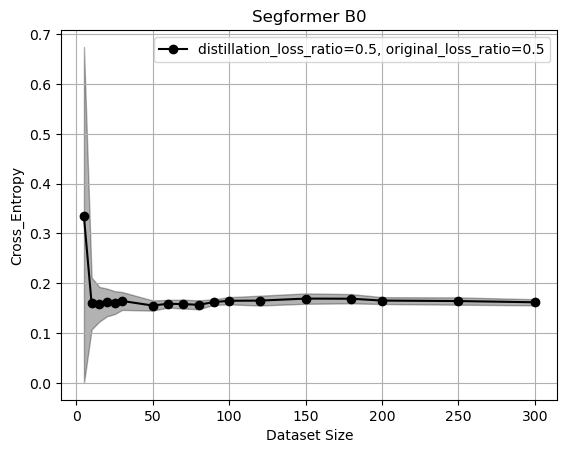

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()